# Import Libraries 

In [2]:
from os import listdir
from os.path import isfile, join

import tensorflow as tf

import logging
import numpy as np
import pandas as pd
import sys
import tensorflow_lattice as tfl
from tensorflow import feature_column as fc
logging.disable(sys.maxsize)
import random
#import pydot
import graphviz
from tensorflow.keras.utils import plot_model
import graphviz
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

#import pydot_ng as pydot
#pydot.find_graphviz()

import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'axes.unicode_minus': False
})
matplotlib.rcParams['axes.unicode_minus'] = False
%matplotlib inline
LEARNING_RATE = 0.1
BATCH_SIZE = 128
NUM_EPOCHS = 15

# Import Data

In [3]:
data_dir = 'C:/Users/rubbi/OneDrive/ClassDocs/CS685PIML/data/B90_102/experiment_30m/HVAC_B90_102_exp_30m_20210426_5mins.csv'
data_df  = pd.read_csv(data_dir , index_col=0)

# Define functions for working with data

In [4]:
def normalize(df):
    norm = pd.DataFrame()
    if isinstance(df, pd.DataFrame):
        for col in df.columns:
            min_val = df[col].min()
            max_val = df[col].max()
            mean_val= df[col].mean()
            df[col] = (df[col]- mean_val) / (max_val - min_val)
            norm[col] = [min_val, max_val, mean_val]
    elif isinstance(df, pd.Series):
        min_val = df.min()
        max_val = df.max()
        mean_val= df.mean()
        df      = (df- mean_val) / (max_val - min_val)
        norm    = [min_val, max_val, mean_val]
    else:
        raise Exception('Invalid datatype')
    return [df, norm]

def denormalize(df, norm_df):
    """
            Denormalize data back to original scale
    """
    new_df = pd.DataFrame()
    if isinstance(df, pd.DataFrame):
        for col in df.columns:
            min_val = norm_df[col].iloc[0]
            max_val = norm_df[col].iloc[1]
            mean_val= norm_df[col].iloc[2]
            new_df[col] = df[col]* (max_val - min_val) +  mean_val
#     elif isinstance(df, pd.Series):
    else:
        min_val = norm_df[0]
        max_val = norm_df[1]
        mean_val= norm_df[2]
        new_df = df * (max_val - min_val) +  mean_val
#     else:
#         raise Exception('Invalid datatype')
    return new_df



def train_test_split_multioutput(x_df, y_df, train_percent):
    x_len = len(x_df)
    y_len = len(y_df)
    x_indices = random.sample(range(0, x_len), int(x_len*train_percent))
    x_train = x_df.loc[x_indices]
    x_test = x_df.drop(x_indices)
    y_indices = random.sample(range(0, y_len), int(y_len*train_percent))
    y_train = y_df.loc[y_indices]
    y_test = y_df.drop(y_indices)
    x_train = x_train.reset_index()
    x_test = x_test.reset_index()
    y_train = y_train.reset_index()
    y_test = y_test.reset_index()
    return(x_train, x_test, y_train, y_test)



# Extract Relevant Data

C:\Users\rubbi\AppData\Local\Temp/ipykernel_22316/3523606664.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_data['sensible_heat_diff_ave'] = relevant_data['sensible_heat_in_ave'] - relevant_data['sensible_heat_room_ave']
C:\Users\rubbi\AppData\Local\Temp/ipykernel_22316/3523606664.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_data['prev_temp'] = relevant_data['room_temp_ave'].shift(1)


Text(0, 0.5, 'room_temp_ave')

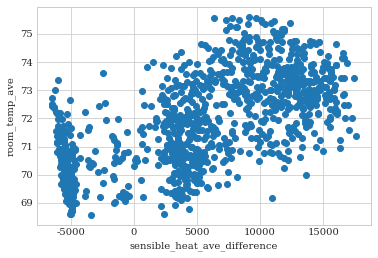

In [7]:
#inputs: prev_thermostat_room_temp, sensible_heat_diff=sensible_heat_in - sensible_heat_room, setpoint
#outputs: thermostat_room_temp, htg_valve_position, airflow
#constraints: thermostat_room_temp monotonic with sensible_heat_diff
#prev_thermostat_room_temp,   

relevant_data = data_df[['room_temp_ave','thermostat_room_temp_ave', 'sensible_heat_in_ave', 'sensible_heat_room_ave', 
                         'setpoint', 'htg_valve_position_ave', 'airflow_current_ave']]
#normalized_data, norm = normalize(extract_df)
#extract_N['prev_temp'] = extract_N['room_temp'].shift(1)
#extract_N.dropna(inplace=True)
#extract_N.reset_index(drop=True, inplace=True)     

relevant_data['sensible_heat_diff_ave'] = relevant_data['sensible_heat_in_ave'] - relevant_data['sensible_heat_room_ave']
relevant_data['prev_temp'] = relevant_data['room_temp_ave'].shift(1)
relevant_data.dropna(inplace=True)
relevant_data.reset_index(drop=True, inplace=True)

X = relevant_data[['prev_temp', 'sensible_heat_diff_ave', 'setpoint']]
Y = relevant_data[['room_temp_ave']]
plt.rc('text', usetex=False)
plt.plot(relevant_data['sensible_heat_diff_ave'], relevant_data['room_temp_ave'],'o')
plt.xlabel("sensible_heat_ave_difference")
plt.ylabel("room_temp_ave")

# Split into training and testing

In [8]:
random.seed(1)
X_train,X_test,y_train,y_test = train_test_split_multioutput(X,Y,0.66)

# Creating Calibrators and Inputs 

In [9]:
lattice_sizes = [3,3]
model_inputs = []
lattice_inputs = []

########previous thermostat room temp calibrator#############
prev_temp_input = tf.keras.layers.Input(shape=[1], name='prev_temp')
model_inputs.append(prev_temp_input)
prev_temp_calibrator = tfl.layers.PWLCalibration(
   input_keypoints = np.linspace(
      X_train['prev_temp'].min(), X_train['prev_temp'].max(), num=30),
    dtype=tf.float64,
    output_min=0.0,
#    output_max=lattice_sizes[0]-1.0,
    name='prev_temp_calib',
    kernel_regularizer=('wrinkle',0.0, 1e-4) 
)(
    prev_temp_input)
lattice_inputs.append(prev_temp_calibrator)

##########sensible heat difference calibrator##################
sensible_heat_diff_input = tf.keras.layers.Input(shape=[1], name='sensible_heat_diff')
model_inputs.append(sensible_heat_diff_input)
sensible_heat_diff_calibrator = tfl.layers.PWLCalibration(
   input_keypoints = np.linspace(
          X_train['sensible_heat_diff_ave'].min(), X_train['sensible_heat_diff_ave'].max(), num=30),
    dtype=tf.float64,
    output_min=0.0,
    output_max=lattice_sizes[0]-1.0,
    name='sensible_heat_diff_calib',
    #kernel_regularizer=('wrinkle',0.0, 1e-4),
    #monotonicity='increasing'
)(
   sensible_heat_diff_input)
lattice_inputs.append(sensible_heat_diff_calibrator)

##########setpoint calibrator####################
setpoint_input = tf.keras.layers.Input(shape=[1], name='setpoint')
#model_inputs.append(setpoint_input)
setpoint_calibrator = tfl.layers.PWLCalibration(
   input_keypoints = np.linspace(
          X_train['setpoint'].min(), X_train['setpoint'].max(), num=30),
    dtype=tf.float64,
    output_min=0.0,
    output_max=lattice_sizes[0]-1.0,
    name='setpoint_calib',
    monotonicity='increasing'
)(
  setpoint_input)
#lattice_inputs.append(setpoint_calibrator)

# Create Lattice Layer

In [10]:
lattice = tfl.layers.Lattice(
    lattice_sizes = lattice_sizes,
    monotonicities=['none', 'none'],
    #monotonicities=['none'],
    name='lattice',
)(
    lattice_inputs) 

model_output = tfl.layers.PWLCalibration(
    input_keypoints=np.linspace(y_train['room_temp_ave'].min(), y_train['room_temp_ave'].max(), 30),
    name='output_calib',
)(
    lattice)


# Create Functional Model

In [12]:
model = tf.keras.models.Model(
    inputs=model_inputs,
    outputs=model_output)
feature_names = ['prev_temp', 'sensible_heat_diff_ave']
#feature_names = ['sensible_heat_diff']

features = np.split(
    X_train[feature_names].values,
    indices_or_sections=len(feature_names),
    axis=1)
target=y_train['room_temp_ave'].values

model.compile(
    loss=tf.keras.losses.mean_squared_error,
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))
model.fit(
    features,
    target,
    batch_size=BATCH_SIZE,
    epochs=10000,
    shuffle=False,
    verbose=0)
model.evaluate(features,target)


24/24 [==============================] - 0s 522us/step - loss: 2.7296


2.7296180725097656

In [13]:
model.get_weights()

[array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]),
 array([[0.        ],
        [0.06896552],
        [0.06896552],
        [0.06896552],
        [0.06896552],
        [0.06896552],
        [0.06896552],
        [0.06896552],
        [0.06896552],
        [0.06896552],
        [0.06896552],
        [0.06896552],
        [0.06896552],
        [0.06896552],
        [0.06896552],
        [0.06896552],
        [0.06896552],
        [0.06896552],
        [0.06896552],
        [0.06896552],
        [0.06896552],
        [0.06896552],
        [0.06896552],
        [0.06896552],
        [0.06896552],
        [0.06896552],
      

AttributeError: module 'tensorflow_lattice.python.estimators' has no attribute 'train'

# View Performance on Training Set

In [18]:
model.predict(features)


array([[71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],
       [71.545235],


# Evaluate on Test Set

In [92]:
test_features = np.split(
    X_test[feature_names].values,
    indices_or_sections=len(feature_names),
    axis=1)
test_target=y_test
model.predict(test_features)

array([[71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
       [71.524574],
